In [15]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

# Read the files
pbp_data = pd.read_csv('/content/drive/My Drive/pbp_stats.csv')
players = pd.read_csv('/content/drive/My Drive/players.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-15-ca8d90e28e5c>:6: DtypeWarning: Columns (45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,253,254,255,260,262,263,283,284,302,332,372,374,375,376,378,380,381,382,388,389,390) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp_data = pd.read_csv('/content/drive/My Drive/pbp_stats.csv')


In [17]:
import pandas as pd



# Define thresholds
WIN_PROB_THRESHOLD = 0.70  # 70% win probability
TIME_THRESHOLD = 600  # Last 10 minutes of the game

# Filter for 4th quarter plays in the last 10 minutes
fourth_quarter_data = pbp_data[
    (pbp_data['qtr'] == 4) &
    (pbp_data['game_seconds_remaining'] <= TIME_THRESHOLD)
]

# Initialize a set to track blown games
blown_games = set()

# Iterate through each game
for game_id, game_data in fourth_quarter_data.groupby('game_id'):
    # Check if the home team had a win probability > threshold
    home_blew = (game_data['home_wp'] > WIN_PROB_THRESHOLD).any()
    # Check if the away team had a win probability > threshold
    away_blew = (game_data['away_wp'] > WIN_PROB_THRESHOLD).any()

    # Get the final result
    final_result = game_data.iloc[-1]  # Last play of the game
    home_won = final_result['home_score'] > final_result['away_score']
    away_won = final_result['away_score'] > final_result['home_score']

    # Check if the home team blew the game
    if home_blew and not home_won:
        blown_games.add((game_id, final_result['home_team'], final_result['away_team']))
    # Check if the away team blew the game
    if away_blew and not away_won:
        blown_games.add((game_id, final_result['away_team'], final_result['home_team']))

# Convert the set to a DataFrame for analysis
blown_games_df = pd.DataFrame(blown_games, columns=['game_id', 'team_that_blew', 'opponent'])
print("Blown Games:")
print(blown_games_df)

# Count how many blown games each team had
blown_games_count = blown_games_df['team_that_blew'].value_counts().reset_index()
blown_games_count.columns = ['team', 'blown_games']
print("\nNumber of Blown Games by Team:")
print(blown_games_count.sort_values(by='blown_games', ascending=False))

Blown Games:
             game_id team_that_blew opponent
0    2024_15_NYJ_JAX            JAX      NYJ
1     2024_18_CHI_GB             GB      CHI
2     2021_15_LV_CLE            CLE       LV
3    2023_09_TEN_PIT            TEN      PIT
4    2021_02_NYG_WAS            NYG      WAS
..               ...            ...      ...
170   2022_16_LV_PIT             LV      PIT
171  2023_02_NYG_ARI            ARI      NYG
172  2022_08_DEN_JAX            JAX      DEN
173  2023_17_ARI_PHI            PHI      ARI
174  2024_10_PIT_WAS            WAS      PIT

[175 rows x 3 columns]

Number of Blown Games by Team:
   team  blown_games
0   BAL           12
2    NO            8
1   TEN            8
3   LAC            7
4    NE            7
5   CHI            7
6   MIN            7
12  IND            6
15  SEA            6
14   LA            6
13  ATL            6
9    SF            6
11  PHI            6
10  HOU            6
8   CIN            6
7   JAX            6
19  BUF            5
20  NYJ      

<ipython-input-24-dda0176d3da4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='blown_games', y='team', data=blown_games_count, palette='viridis')


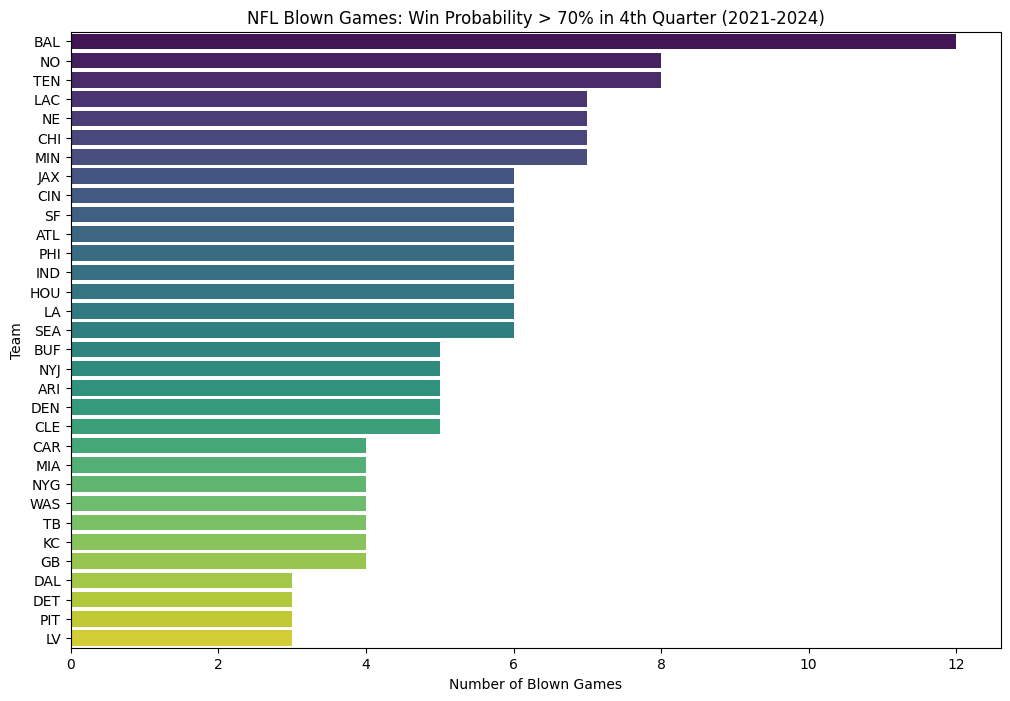

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the data for better visualization
blown_games_count = blown_games_count.sort_values(by='blown_games', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='blown_games', y='team', data=blown_games_count, palette='viridis')
plt.title('NFL Blown Games: Win Probability > 70% in 4th Quarter (2021-2024)')
plt.xlabel('Number of Blown Games')
plt.ylabel('Team')
plt.show()

In [26]:
import pandas as pd



# Define thresholds
WIN_PROB_THRESHOLD = 0.70  # 70% win probability
TIME_THRESHOLD = 600  # Last 10 minutes of the game

# Filter for Ravens games
ravens_games = pbp_data[(pbp_data['home_team'] == 'BAL') | (pbp_data['away_team'] == 'BAL')]

# Initialize a list to store blown games
blown_games = []

# Iterate through each Ravens game
for game_id, game_data in ravens_games.groupby('game_id'):
    # Check if the Ravens had a win probability > threshold in the 4th quarter
    if 'BAL' in game_data['posteam'].values:
        ravens_wp = game_data[game_data['posteam'] == 'BAL']['wp'].max()
    else:
        ravens_wp = game_data[game_data['defteam'] == 'BAL']['def_wp'].max()

    # Check if the Ravens lost the game
    final_result = game_data.iloc[-1]  # Last play of the game
    if final_result['home_team'] == 'BAL':
        ravens_won = final_result['home_score'] > final_result['away_score']
    else:
        ravens_won = final_result['away_score'] > final_result['home_score']

    # If Ravens had a high win probability but lost, add to blown games
    if ravens_wp > WIN_PROB_THRESHOLD and not ravens_won:
        blown_games.append((game_id, final_result['home_team'], final_result['away_team'], final_result['home_score'], final_result['away_score'], ravens_wp))

# Convert the list to a DataFrame for analysis
blown_games_df = pd.DataFrame(blown_games, columns=['game_id', 'home_team', 'away_team', 'home_score', 'away_score', 'max_ravens_wp'])
print("Ravens Blown Games:")
print(blown_games_df)

# Save the blown games to a CSV for further analysis
blown_games_df.to_csv('ravens_blown_games.csv', index=False)

Ravens Blown Games:
            game_id home_team away_team  home_score  away_score  max_ravens_wp
0    2021_01_BAL_LV        LV       BAL          33          27       0.857114
1   2021_13_BAL_PIT       PIT       BAL          20          19       0.825142
2    2021_15_GB_BAL       BAL        GB          30          31       0.701616
3    2021_17_LA_BAL       BAL        LA          19          20       0.883898
4   2021_18_PIT_BAL       BAL       PIT          13          16       0.832329
5   2022_02_MIA_BAL       BAL       MIA          38          42       0.984747
6   2022_04_BUF_BAL       BAL       BUF          20          23       0.941392
7   2022_06_BAL_NYG       NYG       BAL          24          20       0.835534
8   2022_12_BAL_JAX       JAX       BAL          28          27       0.825360
9   2022_17_PIT_BAL       BAL       PIT          13          16       0.842111
10  2023_03_IND_BAL       BAL       IND          19          22       0.898285
11  2023_05_BAL_PIT       PIT   

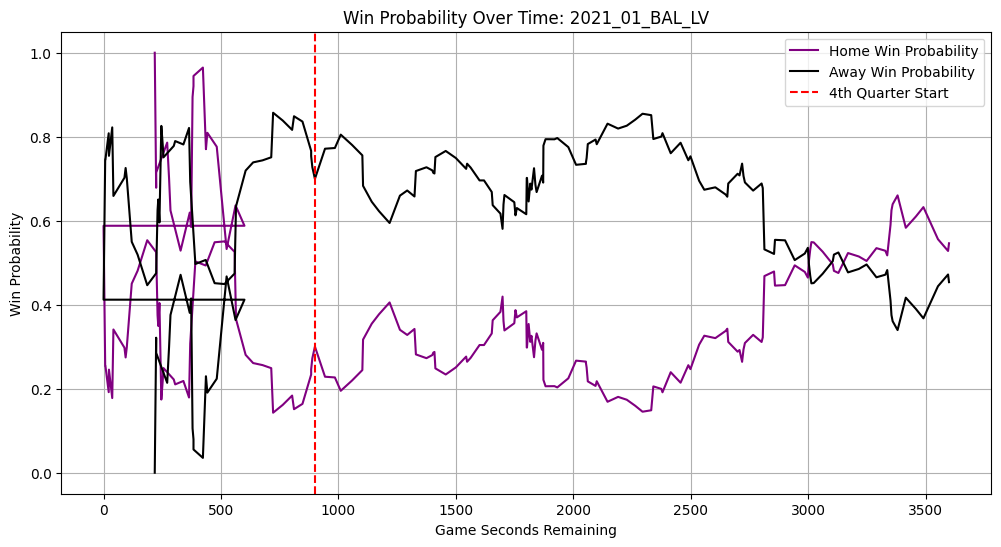

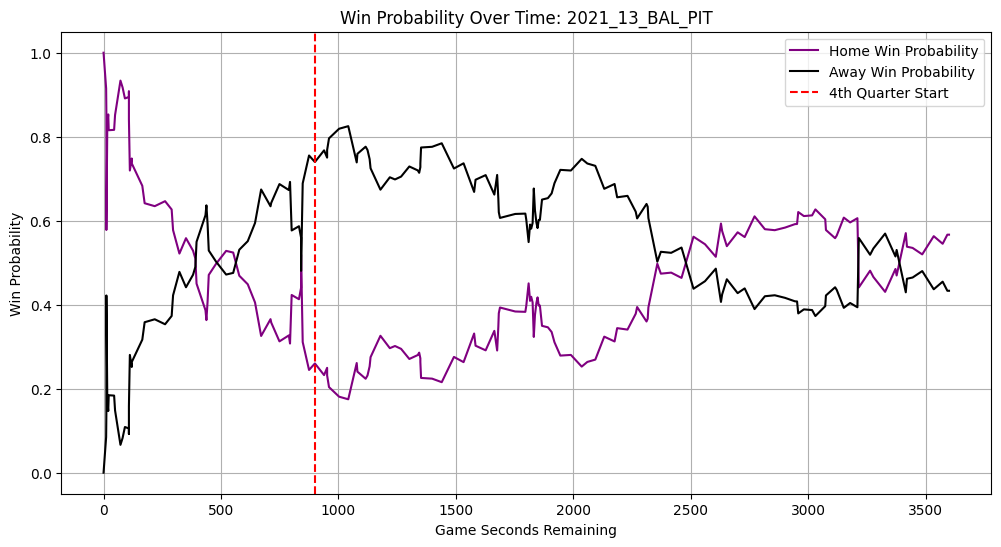

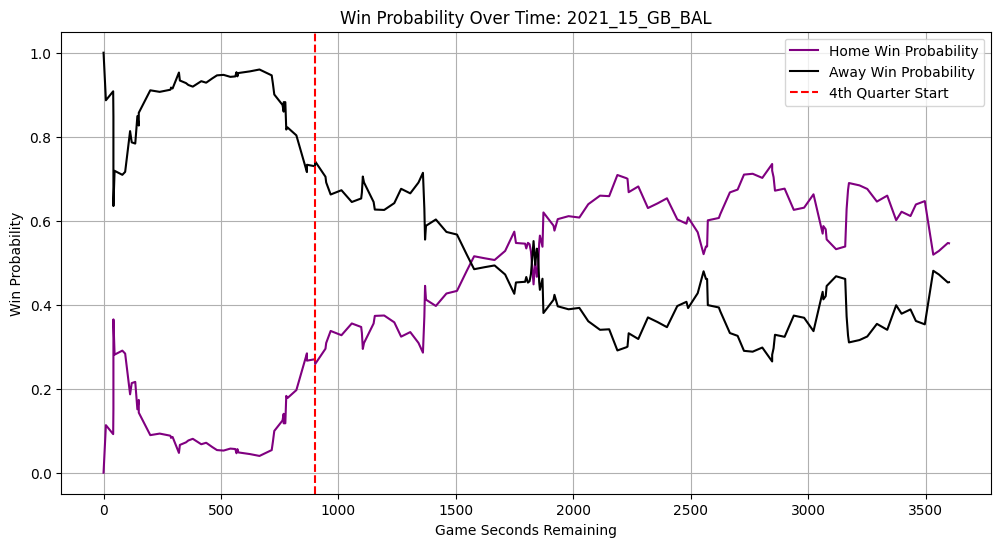

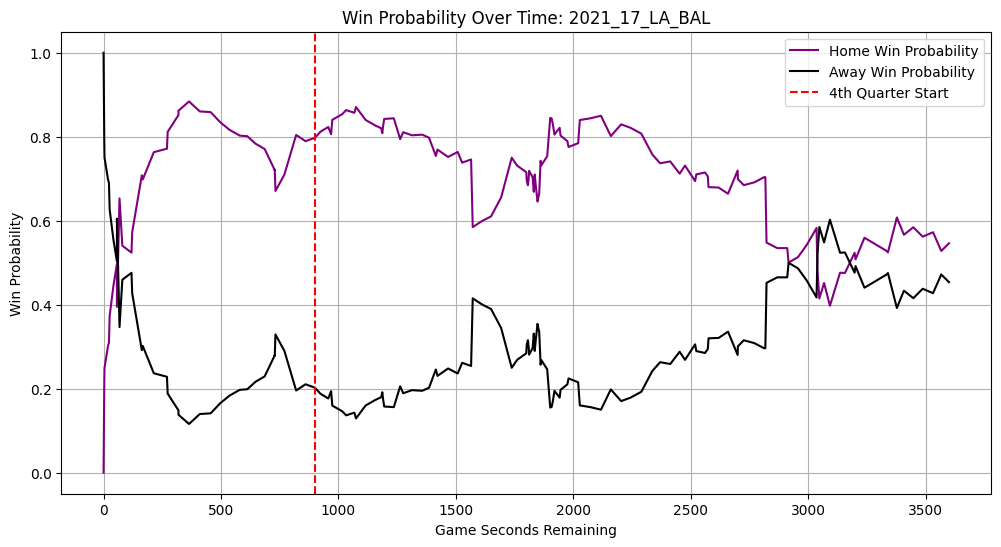

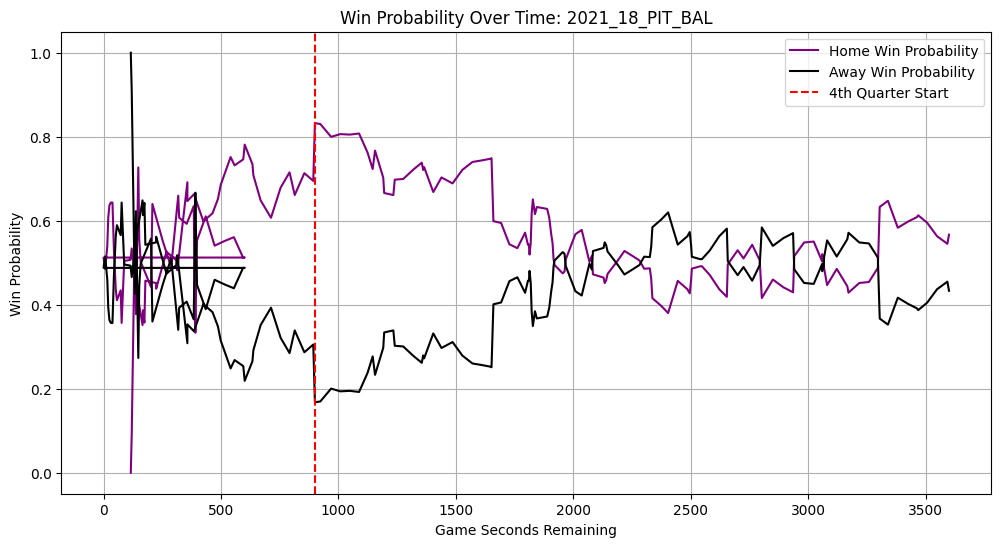

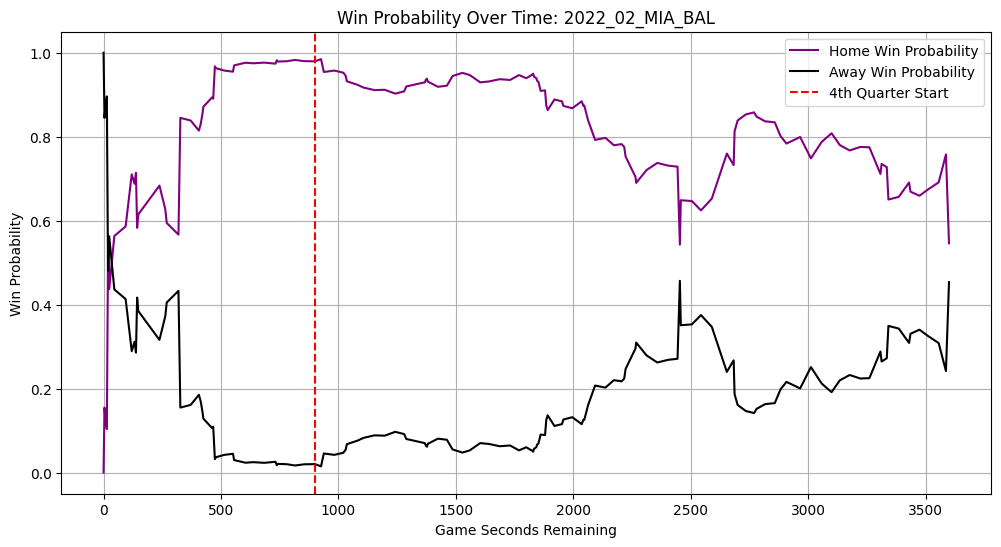

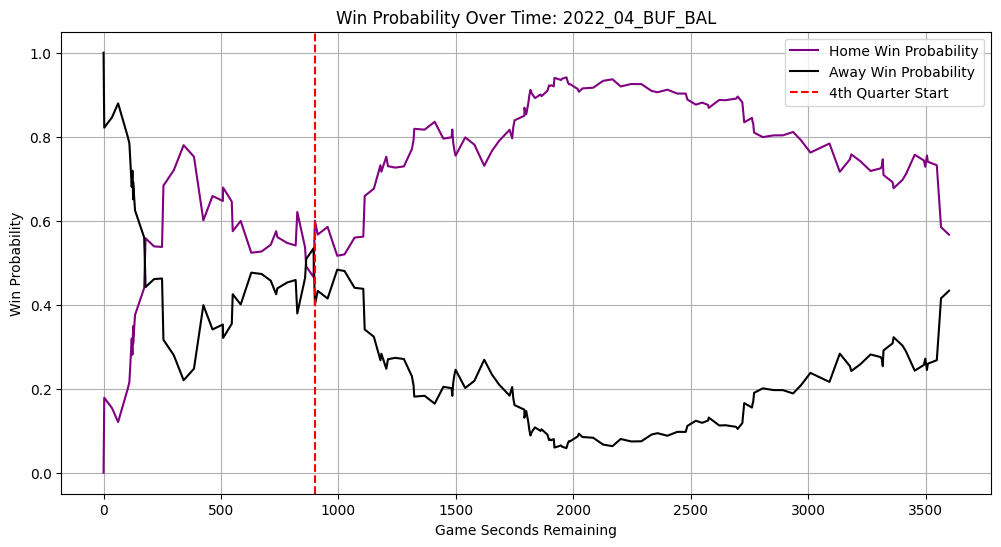

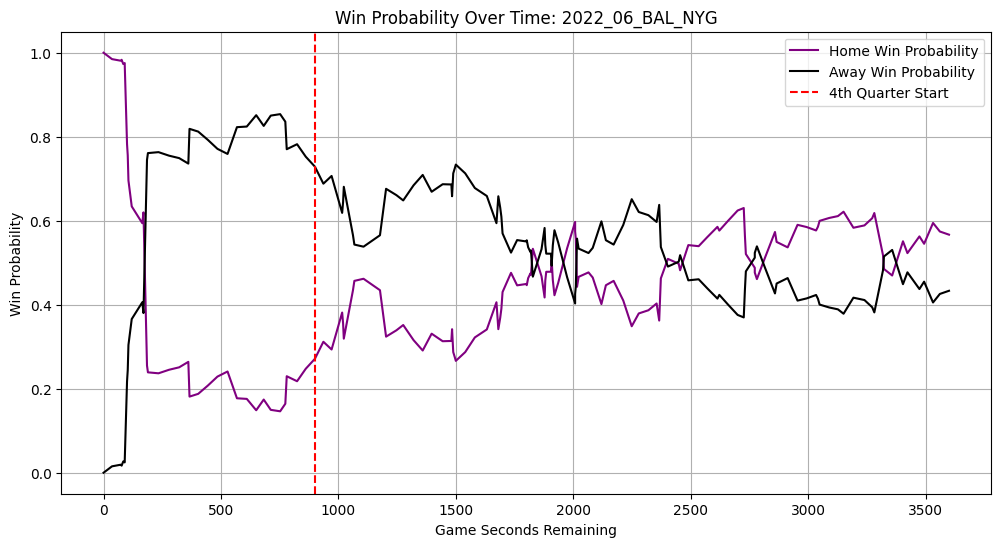

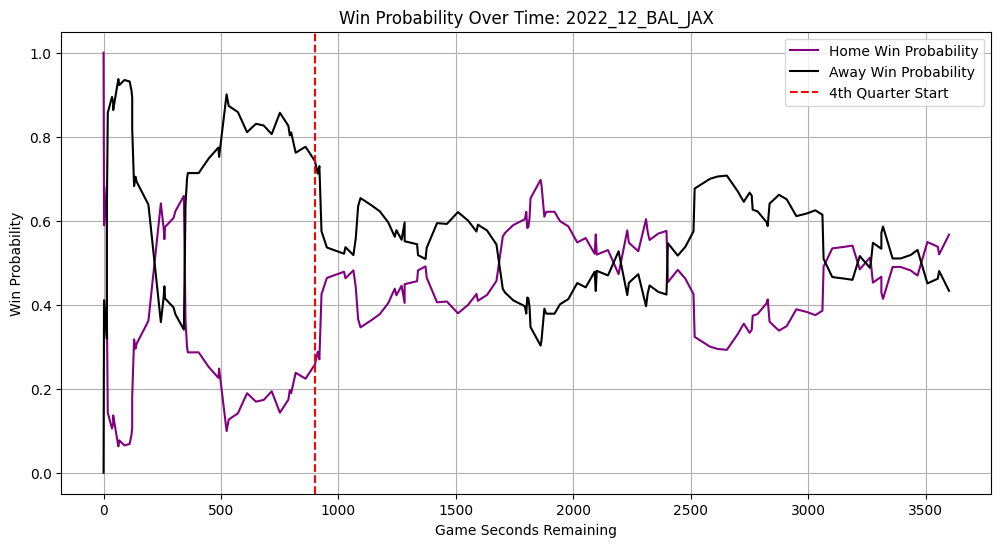

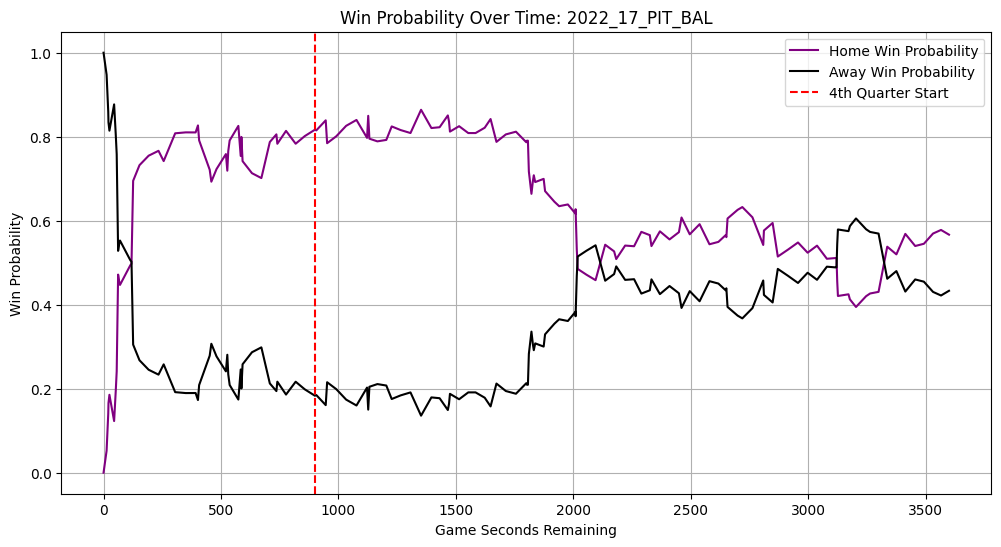

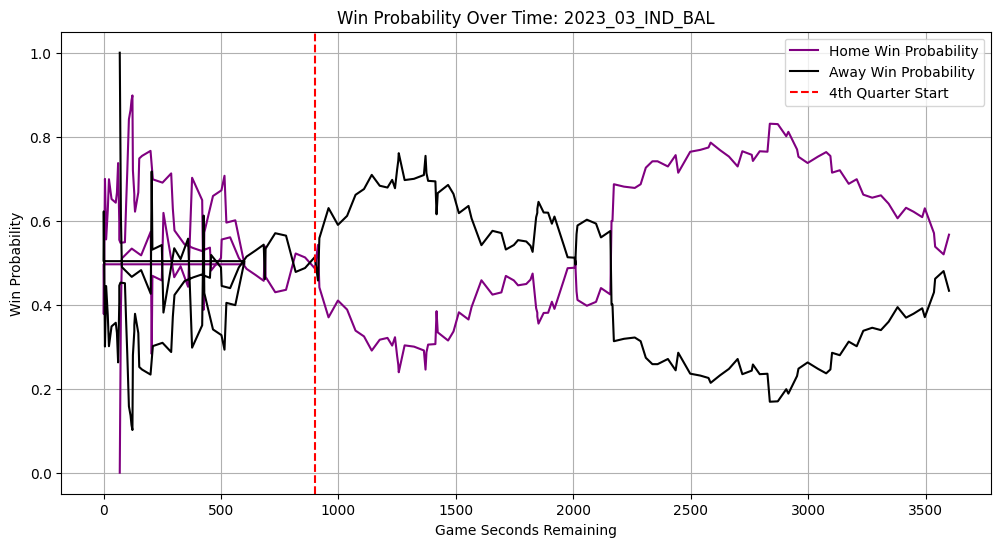

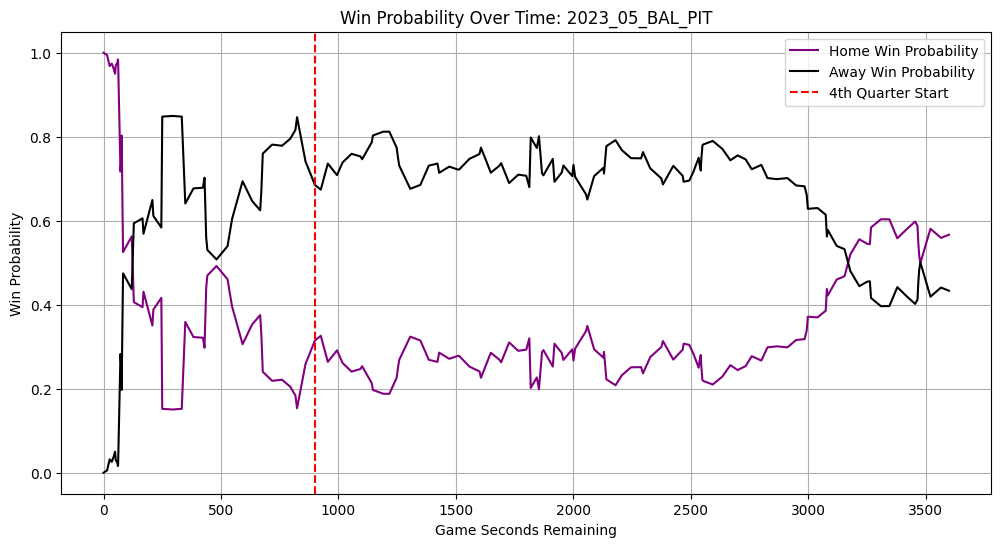

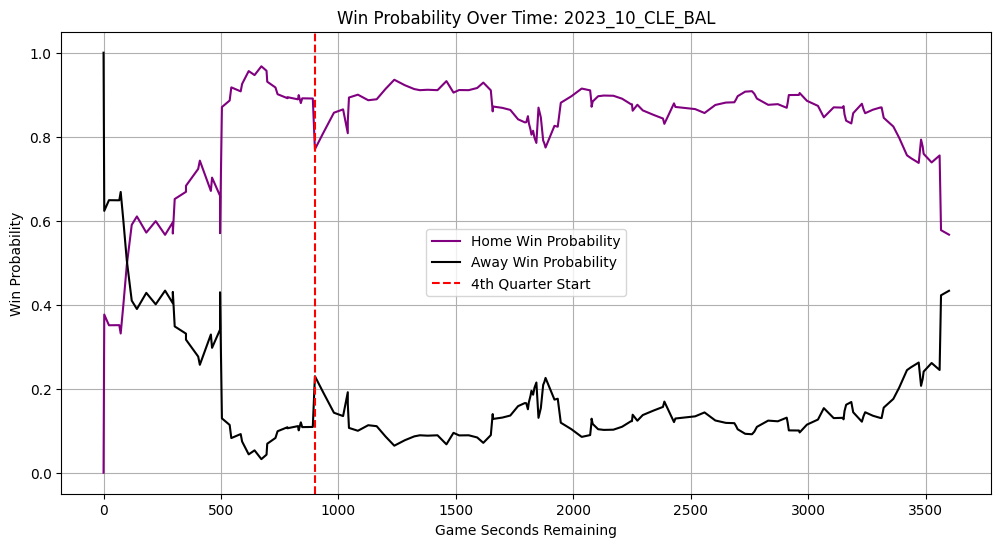

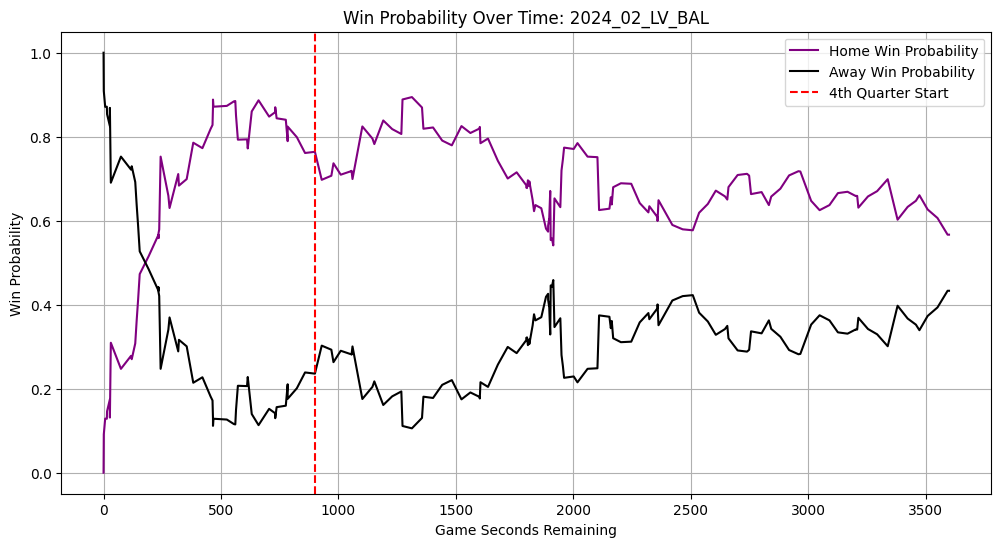

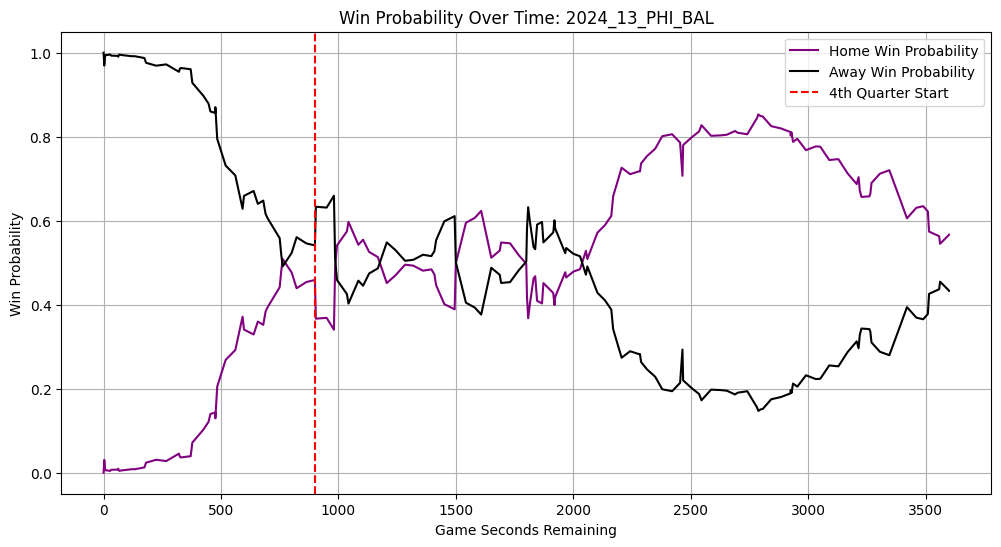

In [28]:
import pandas as pd
import matplotlib.pyplot as plt



# List of blown games (from your data)
blown_games = [
    '2021_01_BAL_LV', '2021_13_BAL_PIT', '2021_15_GB_BAL', '2021_17_LA_BAL',
    '2021_18_PIT_BAL', '2022_02_MIA_BAL', '2022_04_BUF_BAL', '2022_06_BAL_NYG',
    '2022_12_BAL_JAX', '2022_17_PIT_BAL', '2023_03_IND_BAL', '2023_05_BAL_PIT',
    '2023_10_CLE_BAL', '2024_02_LV_BAL', '2024_13_PHI_BAL'
]

# Plot win probability for each game
for game_id in blown_games:
    # Filter data for the game
    game_data = pbp_data[pbp_data['game_id'] == game_id]

    # Plot win probability over time
    plt.figure(figsize=(12, 6))
    plt.plot(game_data['game_seconds_remaining'], game_data['home_wp'], label='Home Win Probability', color='purple')
    plt.plot(game_data['game_seconds_remaining'], game_data['away_wp'], label='Away Win Probability', color='black')

    # Highlight the 4th quarter (last 900 seconds)
    plt.axvline(x=900, color='red', linestyle='--', label='4th Quarter Start')

    # Add labels and title
    plt.xlabel('Game Seconds Remaining')
    plt.ylabel('Win Probability')
    plt.title(f'Win Probability Over Time: {game_id}')
    plt.legend()
    plt.grid()

    # Save the plot
    plt.savefig(f'{game_id}_win_prob.png', bbox_inches='tight')
    plt.show()